In [1]:
#! C:\Users\DELL\Downloads\heart disease prediction\myenv\Scripts\python.exe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, PrecisionRecallDisplay
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.animation import FuncAnimation
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


import warnings
warnings.filterwarnings("ignore")

Data Collection and Preprocessing

In [2]:
heart=pd.read_csv("heart.csv")

In [3]:
heart.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [3]:
#lets drop id as it is not relavent
heart.drop("id",axis=1,inplace=True)

In [5]:
heart.shape

(70000, 12)

In [4]:
# Convert age from days to years
heart['age'] = (heart['age'] / 365).round().astype(int)
heart.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
heart.duplicated().sum()
heart.drop_duplicates(inplace=True)
heart.shape

(66184, 12)

In [6]:

heart.nunique()

age             28
gender           2
height         109
weight         287
ap_hi          153
ap_lo          157
cholesterol      3
gluc             3
smoke            2
alco             2
active           2
cardio           2
dtype: int64

In [7]:
heart["bmi"] = heart["weight"] / (heart["height"]/100)**2


trying to figure out how separate distributions of CVD patients and non-CVD patients look like in terms of height feature:

In [8]:
heart.drop(["weight","height"],axis=1,inplace=True)

In [9]:
heart.head(5)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,110,80,1,1,0,0,1,0,21.967120
1,55,1,140,90,3,1,0,0,1,1,34.927679
2,52,1,130,70,3,1,0,0,0,1,23.507805
3,48,2,150,100,1,1,0,0,1,1,28.710479
4,48,1,100,60,1,1,0,0,0,0,23.011177


check for outliers

<Figure size 9360x5760 with 0 Axes>

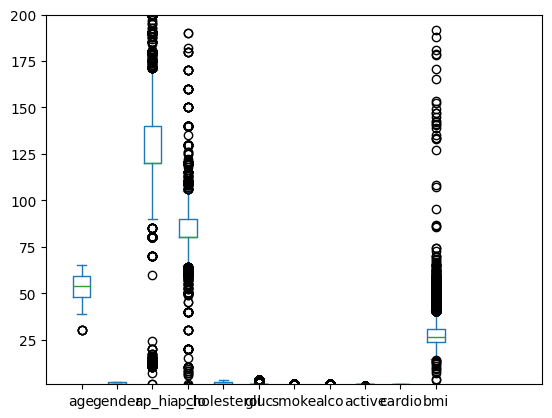

In [10]:
plt.figure(num=None, figsize=(10.4, 6.4), dpi=900, facecolor='w', edgecolor='k')
heart.plot(kind='box')
plt.axis(xmin=0,xmax=14,ymin=1,ymax=200)
plt.show();

In some cases diastolic pressure is higher than systolic, which is incorrect. How many records are inaccurate in terms of blood pressure?

In [11]:
print("Diastolic pressure is higher than systolic one in {0} cases".format(heart[heart['ap_lo']> heart['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 1233 cases


Let's get rid of the outliers, moreover blood pressure could not be negative value!

In [12]:
print('Maximum systolic pressure:',heart["ap_hi"].max())
print('Minimum systolic pressure:', heart["ap_hi"].min())
print('Number of systolic pressure variables:', heart["ap_hi"].nunique())

Maximum systolic pressure: 16020
Minimum systolic pressure: -150
Number of systolic pressure variables: 153


In [13]:
print('Maximum diastolic pressure:',heart["ap_lo"].max())
print('Minimum diastolic pressure:', heart["ap_lo"].min())
print('Number of diastolic pressure variables:', heart["ap_lo"].nunique())

Maximum diastolic pressure: 11000
Minimum diastolic pressure: -70
Number of diastolic pressure variables: 157


In [14]:
#out_filter = ((heart["ap_hi"]>250) | (heart["ap_lo"]>200)) --> more restrictive
out_filter = ((heart["ap_hi"]>175) | (heart["ap_lo"]>120))
heart = heart[~out_filter]
len(heart)

64222

In [15]:
# out_filter2 = ((heart["ap_hi"] < 0) | (heart["ap_lo"] < 0)) -->more restrictive
out_filter2 = ((heart["ap_hi"] < 75) | (heart["ap_lo"] < 50))
heart = heart[~out_filter2]
len(heart)

63961

In [16]:
heart[heart['ap_lo']> heart['ap_hi']].shape[0]  #34 is very less in 70k

34

In [17]:
#Collapse ap_hi into fewer groups
ranges = [0, 130, 180, 320]
group_names = ['Normal', 'Hypertension', 'Hypertensive crisis']
heart['systolic'] = pd.cut(heart['ap_hi'], bins=ranges, labels=group_names)
heart['systolic'].unique()

['Normal', 'Hypertension']
Categories (3, object): ['Normal' < 'Hypertension' < 'Hypertensive crisis']

In [18]:
#Collapse ap_lo into fewer groups
ranges = [-1, 81, 120, 201]
group_names = ['Normal', 'Hypertension', 'Hypertensive crisis']
heart['diastolic'] = pd.cut(heart['ap_lo'], bins=ranges, labels=group_names)
heart['diastolic'].unique()

['Normal', 'Hypertension']
Categories (3, object): ['Normal' < 'Hypertension' < 'Hypertensive crisis']

Let's remove bmi

In [19]:
print('Maximum body mass index:',heart["bmi"].max())
print('Minimum body mass index:', heart["bmi"].min())
print('Number of body mass index:', heart["bmi"].nunique())

Maximum body mass index: 298.6666666666667
Minimum body mass index: 3.471783865673526
Number of body mass index: 3736


In [20]:
# out_filter2 = ((heart["bmi"]>150))
out_filter2 = ((heart["bmi"]>50))
heart = heart[~out_filter2]
len(heart)

63739

Body Mass Index (BMI):
BMI = mass(kg) / height(m2)
Normal BMI values are said to be from 18.5 to 25.
Drinking women have higher risks for CVD than drinking men based on thier BMI.

In [21]:
#Collapse bmi into fewer groups
ranges = [0, 19, 25, 30, 160]
group_names = ['Underweight', 'Normal', 'Overweight', 'Obesity']
heart['bmi_group'] = pd.cut(heart['bmi'], bins=ranges, labels=group_names)
heart['bmi_group'].unique()

['Normal', 'Obesity', 'Overweight', 'Underweight']
Categories (4, object): ['Underweight' < 'Normal' < 'Overweight' < 'Obesity']

<Axes: >

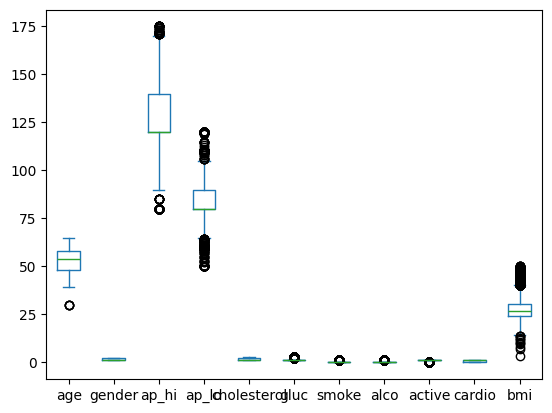

In [22]:
# plt.figure(num=None, figsize=(10.4, 6.4), dpi=900, facecolor='w', edgecolor='k')
heart.plot(kind='box')
# plt.axis(xmin=0,xmax=14,ymin=-1,ymax=5)
# plt.show();

In [23]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63739 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          63739 non-null  int64   
 1   gender       63739 non-null  int64   
 2   ap_hi        63739 non-null  int64   
 3   ap_lo        63739 non-null  int64   
 4   cholesterol  63739 non-null  int64   
 5   gluc         63739 non-null  int64   
 6   smoke        63739 non-null  int64   
 7   alco         63739 non-null  int64   
 8   active       63739 non-null  int64   
 9   cardio       63739 non-null  int64   
 10  bmi          63739 non-null  float64 
 11  systolic     63739 non-null  category
 12  diastolic    63739 non-null  category
 13  bmi_group    63739 non-null  category
dtypes: category(3), float64(1), int64(10)
memory usage: 6.0 MB


In [24]:
heart.describe()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000,63739.000000
mean,53.318486,1.356140,126.169645,81.129591,1.379689,1.234911,0.092361,0.056057,0.797314,0.503130,27.474010
std,6.817238,0.478861,15.615916,9.280582,0.688366,0.581246,0.289537,0.230033,0.402004,0.499994,5.090400
min,30.000000,1.000000,80.000000,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,48.000000,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,26.502116
75%,58.000000,2.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.385016
max,65.000000,2.000000,175.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,50.000000


Thankfully, no NaN values

Now, ananlyzing the traget variable

In [25]:
heart["cardio"].describe()

count    63739.000000
mean         0.503130
std          0.499994
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: cardio, dtype: float64

In [26]:
heart["cardio"].unique()


array([0, 1])

Clearly, this is a classification problem, with the target variable having values '0' and '1'

In [27]:
diseased=(len(heart[heart.cardio==1])/len(heart.cardio))*100
diseased_male=len(heart[(heart.cardio==1) & (heart.gender==1)])/len(heart.cardio)*100
diseased_female=len(heart[(heart.cardio==1) & (heart.gender==2)])/len(heart.cardio)*100

print("\n{:.2f}% of the total count were diseased,\n amoung which {:.2f}% were female  and {:.2f}% were male ".format(diseased,diseased_male,diseased_female))


50.31% of the total count were diseased,
 amoung which 32.42% were female  and 17.90% were male 


In [28]:
non_diseased = (len(heart[heart.cardio == 0]) / len(heart.cardio)) * 100
non_diseased_male = len(heart[(heart.cardio == 0) & (heart.gender == 1)]) / len(heart.cardio) * 100
non_diseased_female = len(heart[(heart.cardio == 0) & (heart.gender == 2)]) / len(heart.cardio) * 100

print(f"\n{non_diseased:.2f}% of the total count were not diseased,\n"
      f"among which {non_diseased_female:.2f}% were female.")


49.69% of the total count were not diseased,
among which 17.72% were female.


In [29]:
#check for correlation among the numerical columns
correlation = heart.select_dtypes('number').corr()
correlation

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
age,1.000000,-0.023855,0.214330,0.153517,0.155715,0.098108,-0.050600,-0.031114,-0.009592,0.235581,0.102540
gender,-0.023855,1.000000,0.057452,0.065376,-0.046261,-0.027027,0.340993,0.170847,0.009207,-0.000855,-0.120184
ap_hi,0.214330,0.057452,1.000000,0.715029,0.185693,0.082658,0.017080,0.026865,0.006627,0.433279,0.256860
ap_lo,0.153517,0.065376,0.715029,1.000000,0.154403,0.067703,0.019187,0.033358,0.002650,0.338046,0.231957
cholesterol,0.155715,-0.046261,0.185693,0.154403,1.000000,0.440743,0.001714,0.027086,0.019288,0.213415,0.161662
gluc,0.098108,-0.027027,0.082658,0.067703,0.440743,1.000000,-0.011460,0.004771,0.000592,0.079339,0.107370
smoke,-0.050600,0.340993,0.017080,0.019187,0.001714,-0.011460,1.000000,0.337089,0.029818,-0.026436,-0.041925
alco,-0.031114,0.170847,0.026865,0.033358,0.027086,0.004771,0.337089,1.000000,0.029045,-0.016735,0.011806
active,-0.009592,0.009207,0.006627,0.002650,0.019288,0.000592,0.029818,0.029045,1.000000,-0.029432,-0.008770
cardio,0.235581,-0.000855,0.433279,0.338046,0.213415,0.079339,-0.026436,-0.016735,-0.029432,1.000000,0.181022


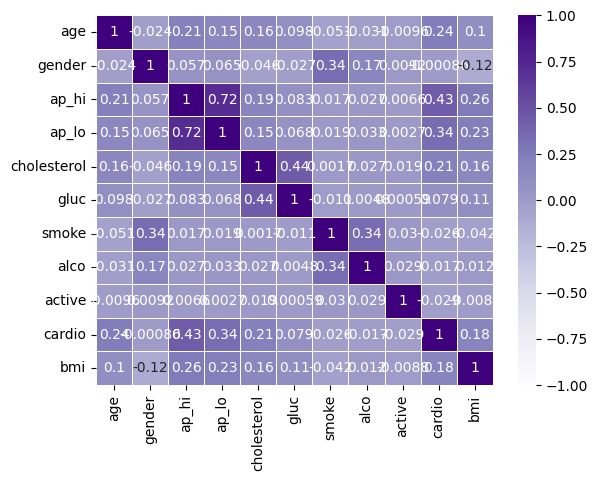

In [32]:
import seaborn as sns
#visualise the correlation
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, cmap='Purples', linewidth=0.5);

here we can see ap_hi and ap_lo are little bit dependent
gluc and cholesterol are also dependent

ANALYZING EDA

cardio
1    32069
0    31670
Name: count, dtype: int64


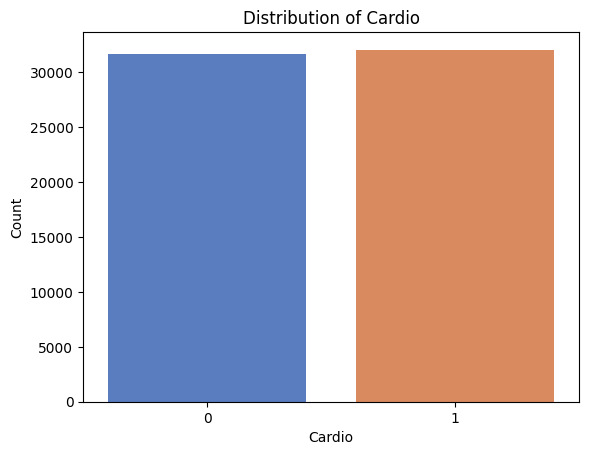

In [32]:

# Check the distribution of the "cardio" column
y = heart["cardio"]
sns.countplot(x=y, palette="muted")

# Calculate and print value counts for the "cardio" column
target_temp = heart["cardio"].value_counts()
print(target_temp)

# Display the plot
plt.title("Distribution of Cardio")
plt.xlabel("Cardio")
plt.ylabel("Count")
plt.show()

#blue= 0, orange=1

<Axes: xlabel='gender', ylabel='cardio'>

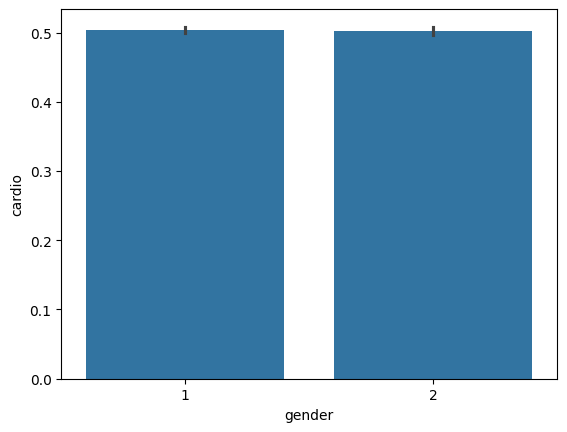

In [34]:
sns.barplot(x=heart["gender"], y=y)
# For each gender (1 and 2), the bar height represents the average value of the "cardio" column:

# If "cardio" is binary (0 or 1), the mean value is equivalent to the proportion of 1s (or the fraction of individuals with cardio issues) in that gender group.
# Example:
# If 50% of individuals with gender 1 have cardio = 1, the bar for gender 1 will be at 0.5.
# If 40% of individuals with gender 2 have cardio = 1, the bar for gender 2 will be at 0.4.

avg value of y for each men and women is ploted, we see data se balanced

<Axes: xlabel='cardio', ylabel='count'>

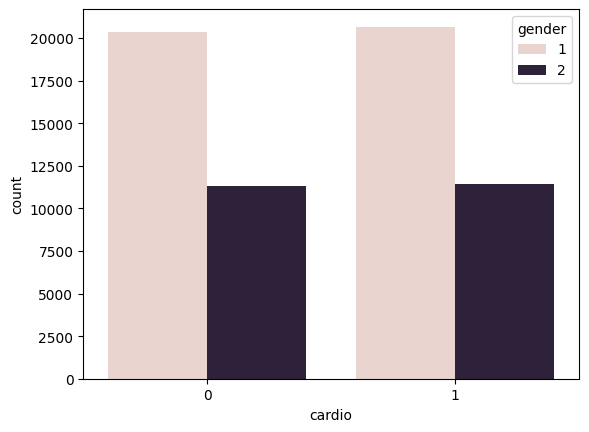

In [35]:
sns.countplot(x='cardio',hue='gender',data=heart)

count of occurance of each category, women have higher  chance

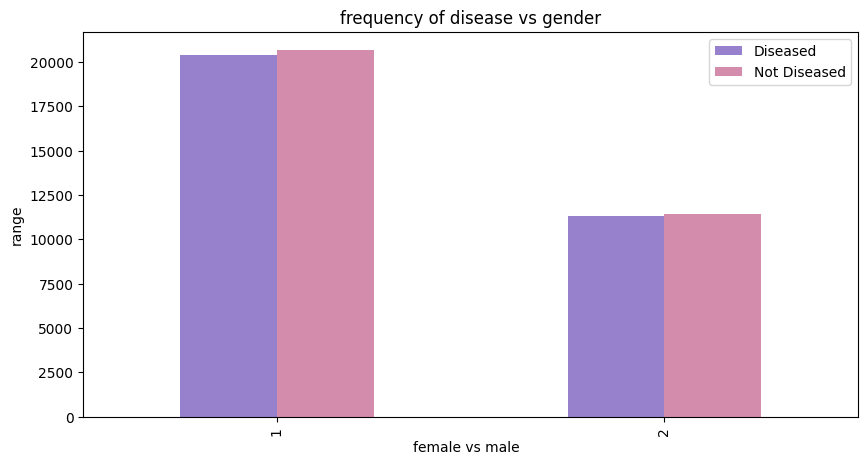

In [36]:
pd.crosstab(heart.gender, heart.cardio).plot(kind="bar",figsize=(10,5),color=['#9781cc','#d48cac' ])
plt.title("frequency of disease vs gender")
plt.ylabel('range')
plt.xlabel('female vs male  ')
plt.legend(["Diseased","Not Diseased"])
plt.show()

<Axes: xlabel='cholesterol', ylabel='cardio'>

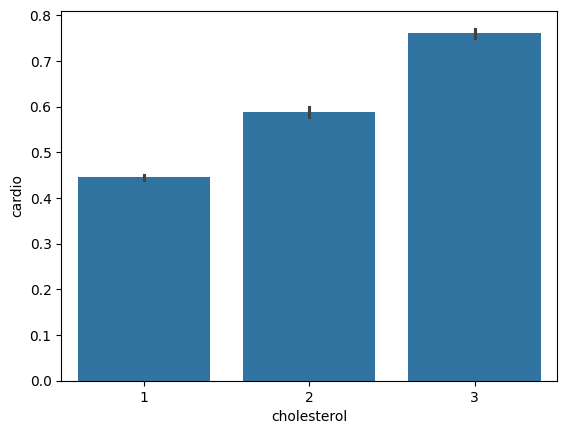

In [37]:
sns.barplot(data=heart,x="cholesterol", y="cardio")
# plt.show()


As the cholesterol level increases (from 1 to 3), the proportion of individuals with cardiovascular disease also seems to increase.

In [38]:
value_counts = heart.groupby(["cholesterol", "cardio"]).size()

print(value_counts)

cholesterol  cardio
1            0         26145
             1         20988
2            0          3707
             1          5304
3            0          1818
             1          5777
dtype: int64


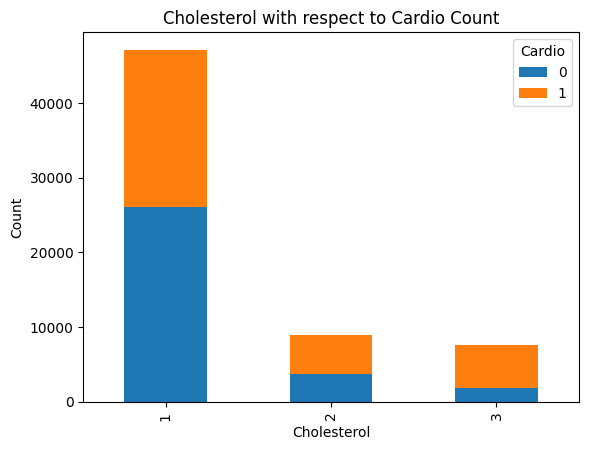

In [39]:

# Calculate the value count of "cardio" for each unique "cholesterol" value
value_counts = heart.groupby("cholesterol")["cardio"].value_counts().unstack()

# Plot the value counts
ax = value_counts.plot(kind="bar", stacked=True)

# Customize the plot
ax.set_xlabel("Cholesterol")
ax.set_ylabel("Count")
ax.set_title("Cholesterol with respect to Cardio Count")
plt.legend(title="Cardio", loc="upper right")

# Display the plot
plt.show()

In [40]:
print(heart.columns)


Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'cardio', 'bmi', 'systolic', 'diastolic',
       'bmi_group'],
      dtype='object')


<Axes: xlabel='gluc', ylabel='cardio'>

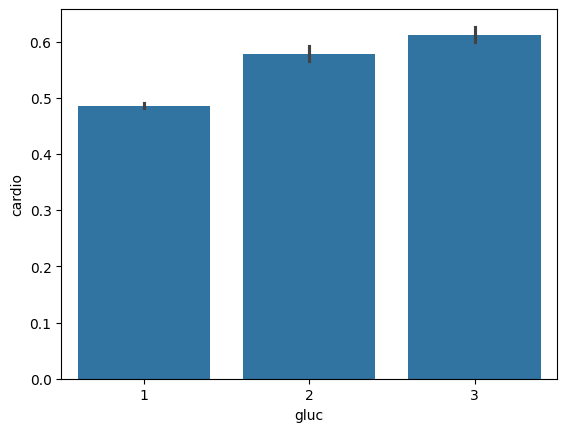

In [41]:
sns.barplot(data=heart,x="gluc", y="cardio")

#1: normal, 2: above normal, 3: well above normal

<Axes: xlabel='smoke', ylabel='cardio'>

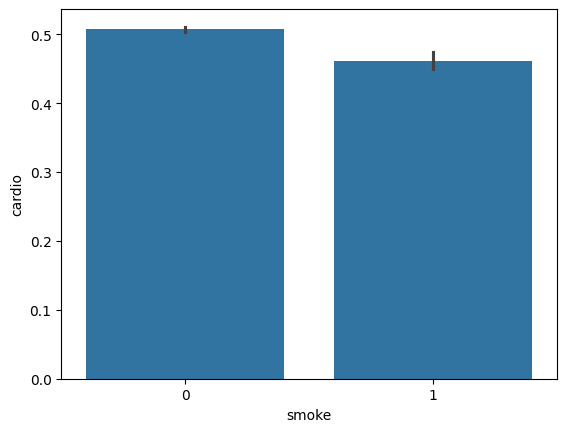

In [42]:
sns.barplot(data=heart,x="smoke", y="cardio")
# plt.show()

<Axes: xlabel='alco', ylabel='cardio'>

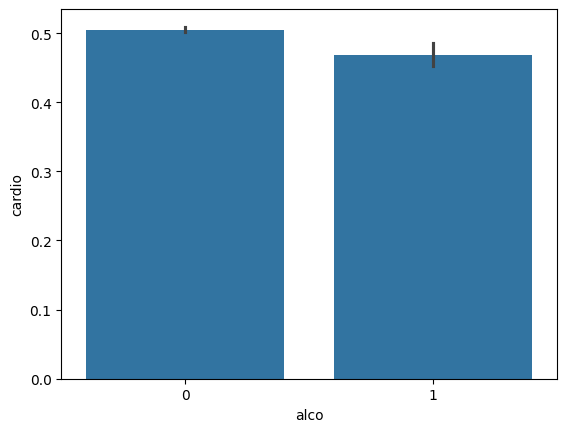

In [43]:
sns.barplot(data=heart,x="alco", y="cardio")
# plt.show()

In [44]:
heart.groupby('gender')['alco'].sum()

gender
1    1101
2    2472
Name: alco, dtype: int64

males have higher alcohol consumption

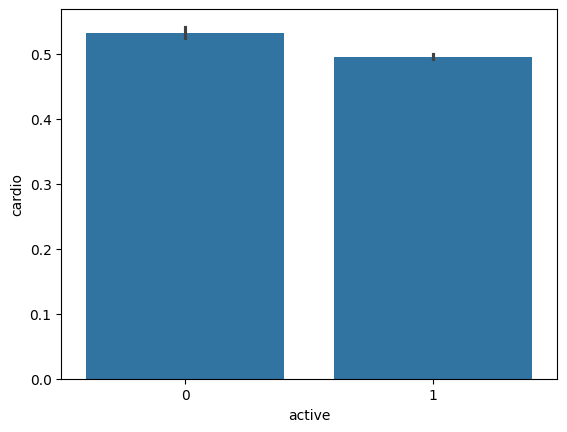

In [45]:
sns.barplot(data=heart,x="active", y="cardio") #physical activity
plt.show()

<Axes: ylabel='Frequency'>

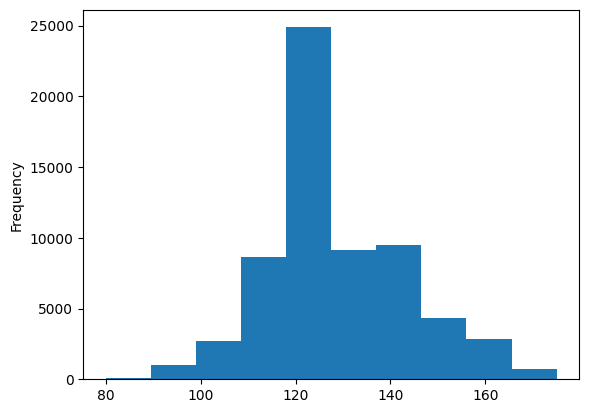

In [46]:
heart['ap_hi'].plot.hist()

The distribution appears to be roughly bell-shaped or normal, with a peak around the 120-125 range. This suggests that a majority of individuals in the dataset have systolic blood pressure values within this range.

<Axes: ylabel='Frequency'>

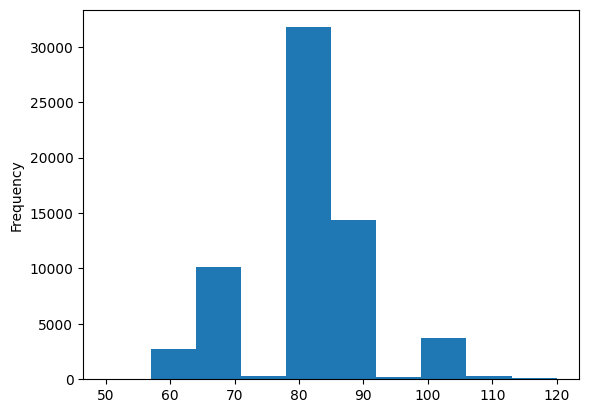

In [47]:
heart['ap_lo'].plot.hist()

 The distribution appears to be skewed to the right. This means that there are more data points with lower diastolic blood pressure values and fewer data points with higher values.
Peak: The distribution has a peak around the 80-85 range, suggesting that this is the most common diastolic blood pressure value in the dataset.

<Axes: ylabel='Frequency'>

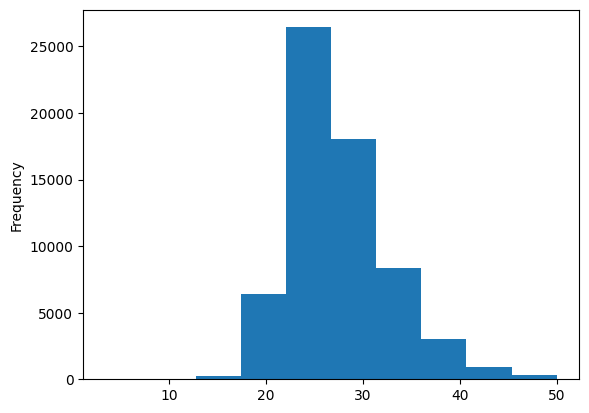

In [48]:
heart['bmi'].plot.hist()

The distribution appears to be skewed to the right. This means that there are more data points with lower BMI values and fewer data points with higher BMI values.

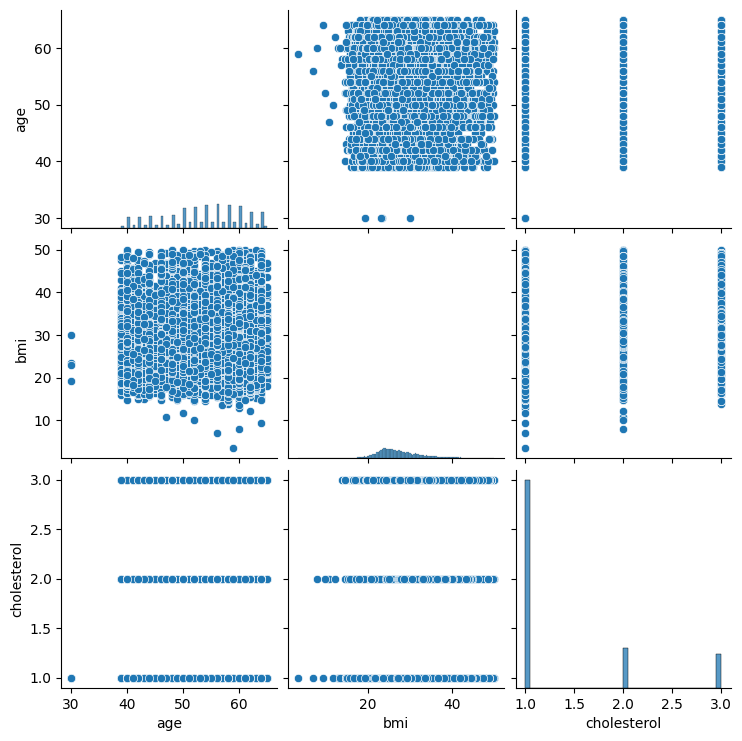

In [49]:
#Visualize the relationships among age, bmi and avg_glucose_level
columns= ['age', 'bmi', 'cholesterol']
sns.pairplot(heart[columns])
plt.show()

Observations:

Age vs. BMI:

The scatter plot indicates that BMI values are mostly concentrated between 20 and 40, regardless of age.
There is no strong trend or clear relationship between age and BMI.

Age vs. Cholesterol:

Cholesterol levels (1, 2, and 3) are categorical, and no specific trend can be observed between age and cholesterol.

BMI vs. Cholesterol:

Similar to age, cholesterol is categorical, and BMI does not exhibit a clear correlation with cholesterol categories.
BMI is clustered between 20 and 40 for all cholesterol levels (1, 2, 3).


Binary encoding

In [30]:
labelencoder = LabelEncoder()
heart['gender']=labelencoder.fit_transform(heart['gender'])

In [31]:

#Encode for categorical columns
#fit divides it into categries
#transform maps categoricak values to integrer representations
cat_cols = ['systolic', 'diastolic', 'bmi_group']

for col in cat_cols:
    heart[col] = labelencoder.fit_transform(heart[col])

In [32]:
heart.sample(5)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,systolic,diastolic,bmi_group
58307,40,1,110,70,2,1,0,0,1,1,24.489796,1,1,0
48802,54,1,130,90,2,1,0,0,1,0,28.685145,1,0,2
20449,52,1,140,90,1,1,0,0,1,1,21.295295,0,0,0
59121,56,0,130,80,1,1,0,0,1,0,26.037494,1,1,2
8017,52,0,150,110,3,2,0,0,1,1,39.564441,0,0,1


Train Test Split

In [38]:
#Splitting attributes and target variable
x = heart.drop(['cardio'], axis=1)
y = heart['cardio']
x.columns



Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'bmi', 'systolic', 'diastolic', 'bmi_group'],
      dtype='object')

In [44]:
y = y.to_frame(name='cardio')

In [45]:
print(type(y))

<class 'pandas.core.frame.DataFrame'>


In [39]:
x.columns

Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'bmi', 'systolic', 'diastolic', 'bmi_group'],
      dtype='object')

In [46]:

y

,cardio
0,0
1,1
2,1
3,1
4,0
...,...
69993,1
69994,1
69995,0
69998,1


z = (v - mean) / standard_deviation

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [40]:
#split data into traning and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
x.columns

Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'bmi', 'systolic', 'diastolic', 'bmi_group'],
      dtype='object')

In [41]:
x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)

In [42]:
x_train.shape
x_test.shape


(15935, 13)

In [43]:
y_train.shape
y_test.shape

(15935,)

LINEAR REGRESSION-  computes the linear relationship between the dependent variable and one or more independent features by fitting a linear equation to observed data.

In [47]:
def multiple_linear_regression(X, y):
    
    # Add a column of ones for the intercept term
#     np.ones((X.shape[0], 1)) creates a NumPy array filled with ones. The shape of this array is (X.shape[0], 1), which means it has the same number of rows as the input feature matrix X and one column. This column of ones is used to represent the intercept term in the linear regression model.
# np.concatenate((...), axis=1) concatenates the column of ones with the original feature matrix X horizontally (along axis=1). This effectively adds a column of ones to the beginning of X.
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    #Normal Equation
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefficients



coefficients = multiple_linear_regression(x_train, y_train)
print("Coefficients:", coefficients)

# Separate intercept and coefficients
intercept = coefficients[0]
slopes = coefficients[1:]

# Make predictions
X_test_with_ones = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)
predictions = X_test_with_ones @ coefficients



Coefficients: [-9.99379289e-01  1.02208764e-02  2.72204546e-03  6.80009744e-03
  7.20288686e-04  8.42736832e-02 -2.05524206e-02 -2.90464173e-02
 -4.14651334e-02 -4.58802886e-02  4.99187533e-03 -1.54829761e-01
 -5.70946679e-02  5.87707602e-03]


Let's say your first feature is "age" and its coefficient is 0.0696776. This would mean that, holding all other features constant, for every one-year increase in age, the model predicts an increase of approximately 0.0696776 in the target variable.

Similarly, if your 12th feature has a coefficient of -0.06922371, this means that a one-unit increase in that feature is associated with a decrease of approximately 0.06922371 in the target variable 

Accuracy- (Number of correct predictions) / (Total number of predictions) 

In [48]:
binary_predictions = np.round(predictions) 
 #This line rounds the predictions to the nearest integer, converting the continuous predictions to binary predictions
X_train_with_ones = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
train_predictions_lr=X_train_with_ones @ coefficients
binary_train_predictions_lr=np.round(train_predictions_lr)
# Calculate accuracy
accuracy_test_lr = accuracy_score(y_test, binary_predictions)
accuracy_train_lr=accuracy_score(y_train,binary_train_predictions_lr)
print(f"Linear Regression Training Accuracy: {accuracy_train_lr}")
print(f"Linear Regression Test Accuracy: {accuracy_test_lr}")


Linear Regression Training Accuracy: 0.720044347753326
Linear Regression Test Accuracy: 0.7258864135550674


Mean squared error -  (1/n) * Σ(yᵢ - ŷᵢ)²

In [49]:
#Evaluate the model (MSE)
mse = np.mean((predictions - y_test)**2)
print(f"Mean Squared Error on test data: {mse}")

Mean Squared Error on test data: 0.18866619503115023


PRECISION - Out of all the instances that the model predicted as positive, how many were actually positive? Formula: (True Positives) / (True Positives + False Positives)

In [50]:
# Calculate precision for the test set
precision_test_lr = precision_score(y_test, binary_predictions)
print(f"Linear Regression Test Precision: {precision_test_lr}")

Linear Regression Test Precision: 0.7794072716162542


In [51]:


# Calculate Recall
recall = recall_score(y_test, binary_predictions) # Use 'weighted' for multi-class
print(f"Recall: {recall}")

# Calculate F1-score (combines precision and recall)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, binary_predictions)  # Use 'weighted' for multi-class
print(f"F1-score: {f1}")

Recall: 0.6356840269125342
F1-score: 0.700247049135328


In [85]:
confusion_matrix(y_test, binary_predictions)

array([[6465, 1444],
       [2924, 5102]])

In [52]:
from sklearn.metrics import r2_score

r2_linear= r2_score(y_test,binary_predictions)
print(f"R-squared value = {r2_linear}")

R-squared value = -0.09651345858290816


RECALL- Out of all the instances that were actually positive, how many did the model correctly predict as positive? Formula: (True Positives) / (True Positives + False Negatives)

F1 SCORE- The harmonic mean of precision and recall. It balances both metrics.   
Formula: 2 * (Precision * Recall) / (Precision + Recall)

In [53]:
from sklearn import svm
sv = svm.SVC(kernel='linear')

sv.fit(x_train, y_train)

y_pred_svm = sv.predict(x_test)

In [54]:
y_pred_svm.shape

(15935,)

In [55]:
y_train.shape

(47804,)

In [56]:
#evaluate and print the train set accuracy
svm_test_accuracy = accuracy_score(y_test, y_pred_svm)
svm_test_accuracy

0.7240665202384687

In [57]:
#training accuracy 
svm_train_accuracy = accuracy_score(y_train, sv.predict(x_train)) # Use x_train and y_train
print(f"SVM Train Accuracy: {svm_train_accuracy}")

SVM Train Accuracy: 0.7155258974144423


In [58]:
# Calculate Precision
precision = precision_score(y_test, y_pred_svm)  # Use 'weighted' for multi-class
print(f"Precision: {precision}")

# Calculate Recall
recall = recall_score(y_test, y_pred_svm) # Use 'weighted' for multi-class
print(f"Recall: {recall}")

# Calculate F1-score (combines precision and recall)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_svm)  # Use 'weighted' for multi-class
print(f"F1-score: {f1}")

Precision: 0.7950886322979346
Recall: 0.6091452778469972
F1-score: 0.6898059964726632


In [84]:
confusion_matrix(y_test, y_pred_svm)

array([[6358, 1551],
       [2864, 5162]])

In [59]:
r2_svm = r2_score(y_test,y_pred_svm)
print(f"R-squared value = {r2_svm}")

R-squared value = -0.10379342431067928


In [62]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Square Error
mse_svm= mean_squared_error(y_test, y_pred_svm)
print (mse_svm)

0.2759334797615312


KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
y_pred_knn=knn.predict(x_test)

In [64]:
y_pred_knn.shape

(15935,)

In [65]:
#evaluate and print the train set accuracy
knn_train_accuracy = accuracy_score(knn.predict(x_train), y_train)
knn_train_accuracy

0.7623420634256548

In [66]:
#evaluate and print the test set accuracy
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)
knn_test_accuracy

0.6990900533417007

In [68]:
# Calculate Precision
precision = precision_score(y_test, y_pred_knn)  # Use 'weighted' for multi-class
print(f"Precision: {precision}")

# Calculate Recall
recall = recall_score(y_test, y_pred_knn) # Use 'weighted' for multi-class
print(f"Recall: {recall}")

# Calculate F1-score (combines precision and recall)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_knn)  # Use 'weighted' for multi-class
print(f"F1-score: {f1}")



Precision: 0.7107632093933464
Recall: 0.6787939197607775
F1-score: 0.694410808743866


In [69]:
confusion_matrix(y_test, y_pred_knn)

array([[5692, 2217],
       [2578, 5448]])

In [70]:
r2_knn = r2_score(y_test,y_pred_knn)
print(f"R-squared value = {r2_knn}")

R-squared value = -0.20370467809181436


In [71]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Square Error
mse_knn= mean_squared_error(y_test, y_pred_knn)
print (mse_knn)

0.30090994665829934


total 15935, 
5692 (TN): Your model correctly predicted 5692 cases where there was no heart disease (or the negative outcome).
2217 (FP): Your model incorrectly predicted 2217 cases as having heart disease (or the positive outcome) when they did not (Type I error).
2578 (FN): Your model incorrectly predicted 2578 cases as not having heart disease (or the negative outcome) when they did (Type II error).
5448 (TP): Your model correctly predicted 5448 cases where there was heart disease (or the positive outcome).

NAIVE BAYES

In [72]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(x_train,y_train)

y_pred_nb = nb.predict(x_test)

In [73]:
y_pred_nb.shape

(15935,)

In [74]:
#evaluate and print the train set accuracy
nb_train_accuracy = accuracy_score(nb.predict(x_train), y_train)
nb_train_accuracy

0.7109656095724207

In [75]:
#evaluate and print the test set accuracy
nb_test_accuracy = accuracy_score(y_test, y_pred_nb)
nb_test_accuracy

0.7175400062754942

In [76]:

recall_NB = recall_score(y_test, y_pred_nb)
f1_NB = f1_score(y_test, y_pred_nb)
precision_NB = precision_score(y_test, y_pred_nb)

print(f'Recall: {recall_NB:.4f}')
print(f'F1 Score: {f1_NB:.4f}')
print(f'Precision: {precision_NB:.4f}')


Recall: 0.6219
F1 Score: 0.6892
Precision: 0.7730


In [77]:
confusion_matrix(y_test, y_pred_nb)

array([[6443, 1466],
       [3035, 4991]])

In [79]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Square Error
mse_nb= mean_squared_error(y_test, y_pred_nb)
print (mse_nb)

0.2824599937245058


In [80]:
r2_nb = r2_score(y_test,y_pred_nb)
print(f"R-squared value = {r2_nb}")

R-squared value = -0.1299008876102723


Random Forest


Selected Features: ['bmi' 'age' 'ap_hi' 'systolic' 'ap_lo' 'cholesterol' 'gluc' 'gender'
 'bmi_group' 'diastolic']
Model Accuracy after Feature Selection: 0.6653278945716975
Model precision after Feature Selection: 0.6650324794705234
Model confusion matrix after Feature Selection: [[5176 2733]
 [2600 5426]]
Model f1 score after Feature Selection: 0.670497374111832
Model mse after Feature Selection: 0.3346721054283025
Model r sqaure error after Feature Selection: -0.33876059400701686
Model recall after Feature Selection: 0.676052828307999


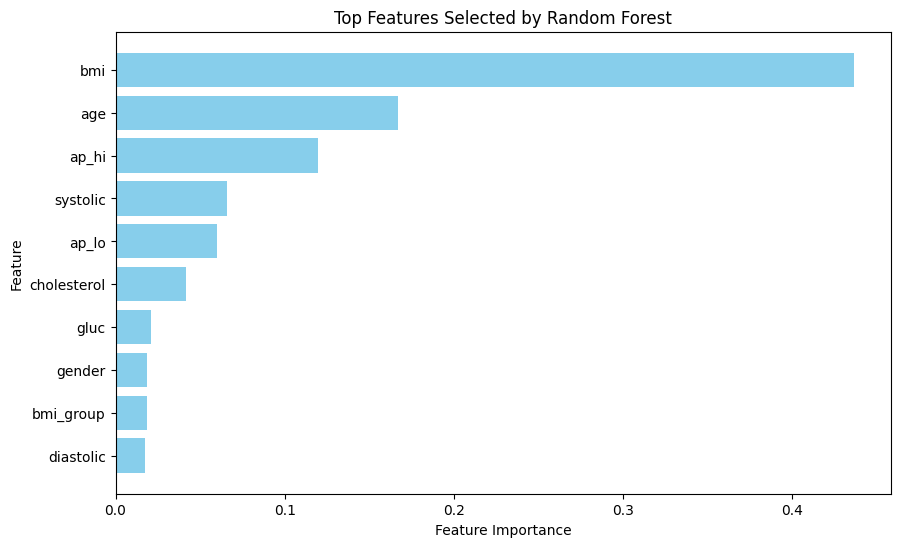

In [81]:

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': x.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the most important features (top N)
N = 10  # Change N based on requirement
selected_features = feature_importances.head(N)['Feature'].values

# Train new model with selected features
X_train_selected = x_train[selected_features]
X_test_selected = x_test[selected_features]

rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = rf_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
r2_rf = r2_score(y_test,y_pred)
mse_rf= mean_squared_error(y_test, y_pred)
cm_rf= confusion_matrix(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)


print("Selected Features:", selected_features)
print("Model Accuracy after Feature Selection:", accuracy)
print("Model precision after Feature Selection:", precision_rf)
print("Model confusion matrix after Feature Selection:", cm_rf)
print("Model f1 score after Feature Selection:", f1_rf)
print("Model mse after Feature Selection:", mse_rf)
print("Model r sqaure error after Feature Selection:", r2_rf)
print("Model recall after Feature Selection:", recall_rf)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:N], feature_importances['Importance'][:N], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top Features Selected by Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [82]:
# # Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train , y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(x_train, y_train)

# Predict and evaluate
y_pred_best = rf_best.predict(x_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
r2_gs = r2_score(y_test,y_pred_best)
mse_gs= mean_squared_error(y_test, y_pred_best)
cm_gs= confusion_matrix(y_test, y_pred_best)
recall_gs = recall_score(y_test, y_pred_best)
f1_gs = f1_score(y_test, y_pred_best)
precision_gs=precision_score(y_test, y_pred_best)


print("Model Accuracy with Optimized Parameters:", accuracy_best)
print("Model precision after Feature Selection:", precision_gs)
print("Model confusion matrix after Feature Selection:", cm_gs)
print("Model f1 score after Feature Selection:", f1_gs)
print("Model mse after Feature Selection:", mse_gs)
print("Model r sqaure error after Feature Selection:", r2_gs)
print("Model recall after Feature Selection:", recall_gs)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Model Accuracy with Optimized Parameters: 0.7304047693755883
Model precision after Feature Selection: 0.7643140589569161
Model confusion matrix after Feature Selection: [[6246 1663]
 [2633 5393]]
Model f1 score after Feature Selection: 0.7151571409627371
Model mse after Feature Selection: 0.26959523062441165
Model r sqaure error after Feature Selection: -0.07843906091395914
Model recall after Feature Selection: 0.6719411911288313


In [83]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM with Gaussian (RBF) kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_selected, y_train)

# Predict on test data
y_pred_svm = svm_rbf.predict(X_test_selected)

# Evaluate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
r2_gsvm=r2_score(y_test,y_pred_best)
mse_gsvm= mean_squared_error(y_test, y_pred_best)
cm_gsvm= confusion_matrix(y_test, y_pred_best)
recall_gsvm= recall_score(y_test, y_pred_best)
f1_gsvm= f1_score(y_test, y_pred_best)
precision_gsvm= precision_score(y_test, y_pred_best)


print("Model Accuracy using Gaussian Kernel SVM:", accuracy_svm)
print("Model precision after Feature Selection:", precision_gsvm)
print("Model confusion matrix after Feature Selection:", cm_gsvm)
print("Model f1 score after Feature Selection:", f1_gsvm)
print("Model mse after Feature Selection:", mse_gsvm)
print("Model r sqaure error after Feature Selection:", r2_gsvm)
print("Model recall after Feature Selection:", recall_gsvm)


Model Accuracy using Gaussian Kernel SVM: 0.7229369312833386
Model precision after Feature Selection: 0.7643140589569161
Model confusion matrix after Feature Selection: [[6246 1663]
 [2633 5393]]
Model f1 score after Feature Selection: 0.7151571409627371
Model mse after Feature Selection: 0.26959523062441165
Model r sqaure error after Feature Selection: -0.07843906091395914
Model recall after Feature Selection: 0.6719411911288313
